# Relax Take Home Challenge

In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from imblearn.over_sampling import SMOTE
pd.set_option('max_columns', 100)
%matplotlib inline

C:\Users\maris\Anaconda3\envs\pymar\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#importing data
users=pd.read_csv('takehome_users.csv', encoding='latin-1')
pd.options.display.max_colwidth=0
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
uses=pd.read_csv('takehome_user_engagement.csv')
pd.options.display.max_colwidth=0
uses.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
uses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
data=uses.groupby('user_id').filter(lambda x: len(x) >= 3)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201002 entries, 1 to 207909
Data columns (total 3 columns):
time_stamp    201002 non-null object
user_id       201002 non-null int64
visited       201002 non-null int64
dtypes: int64(2), object(1)
memory usage: 6.1+ MB


In [7]:
data.reset_index(drop=True, inplace = True)

In [8]:
#identify active users by using timestamps to see if a user logged on more than 3 times in one week
active = 0
object_id = []
for i in range(len(data)-2):
    user = data['user_id'][i] 
    if user != active and user == data['user_id'][i+2]: 
        st = pd.Timestamp(data['time_stamp'][i]) 
        et = st + pd.Timedelta('7D') 
        if st < pd.Timestamp(data['time_stamp'][i+1]) < et and st < pd.Timestamp(data['time_stamp'][i+2]) < et:
            object_id.append(user) 
            active = user                  

In [9]:
#creating a new dataframe of active users id's
act=pd.DataFrame(object_id,columns = ['object_id'])

In [10]:
#creating new column indicating the user is active
act['active']="yes"

In [11]:
act.head()

,object_id,active
0,2,yes
1,10,yes
2,20,yes
3,33,yes
4,42,yes


In [12]:
act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 2 columns):
object_id    1602 non-null int64
active       1602 non-null object
dtypes: int64(1), object(1)
memory usage: 25.1+ KB


In [13]:
#merging active users with users dataframe
full=users.merge(act, how='left', on='object_id')

In [14]:
#replacing null values with no
full['active']=full['active'].fillna("no")

In [15]:
#verifying the merge was complete
full['active'].value_counts()

no     10398
yes    1602 
Name: active, dtype: int64

In [16]:
full.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,no
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,yes
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,no
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,no
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,no


In [17]:
full.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


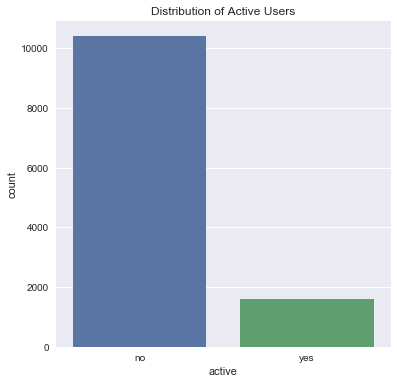

In [18]:
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Distribution of Active Users')
sns.countplot(x = 'active', data = full)

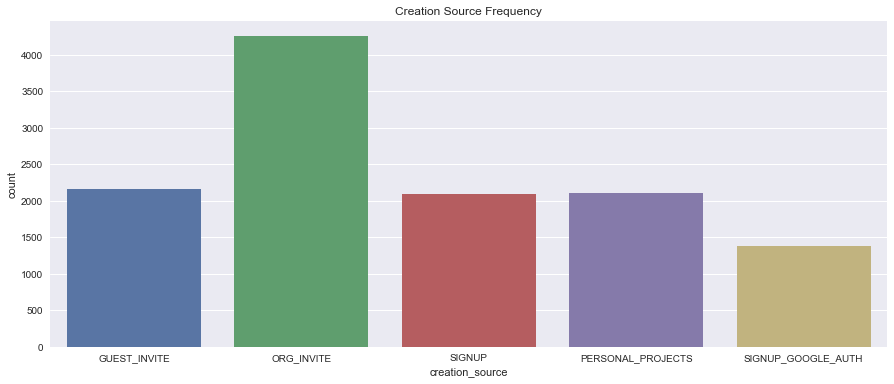

In [19]:
sns.set(rc={'figure.figsize':(15,6)})
plt.title('Creation Source Frequency')
sns.countplot(x = 'creation_source', data = full)

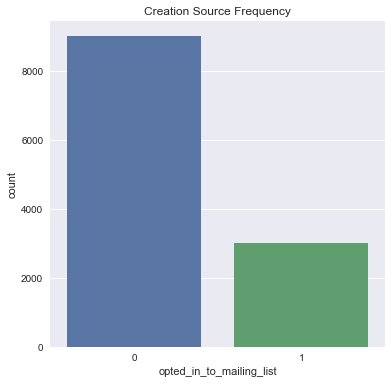

In [20]:
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Creation Source Frequency')
sns.countplot(x = 'opted_in_to_mailing_list', data = full)

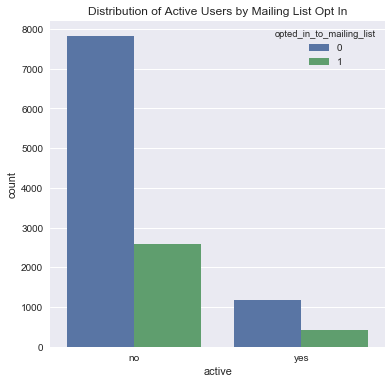

In [21]:
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Distribution of Active Users by Mailing List Opt In')
sns.countplot(x = 'active', hue='opted_in_to_mailing_list', data = full)

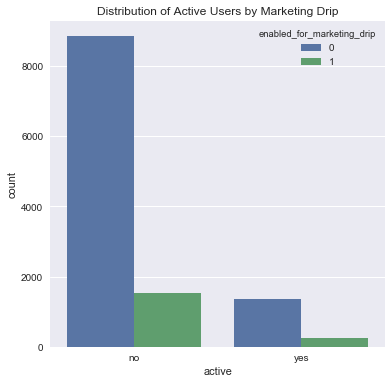

In [22]:
sns.set(rc={'figure.figsize':(6,6)})
plt.title('Distribution of Active Users by Marketing Drip')
sns.countplot(x = 'active', hue='enabled_for_marketing_drip', data = full)

In [23]:
full['invited_by_user_id'].value_counts()

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
10628.0    10
7012.0     10
4612.0     10
4803.0     10
1175.0     10
8068.0     10
4302.0     10
2354.0     10
6370.0     10
10481.0    10
9434.0     9 
9023.0     9 
2922.0     9 
4551.0     9 
6645.0     9 
7698.0     9 
3789.0     9 
3721.0     9 
8554.0     9 
3944.0     9 
7716.0     9 
6808.0     9 
6493.0     9 
8426.0     9 
264.0      8 
          .. 
4885.0     1 
5563.0     1 
4231.0     1 
3418.0     1 
7837.0     1 
3814.0     1 
4655.0     1 
10417.0    1 
7979.0     1 
5638.0     1 
3422.0     1 
6164.0     1 
594.0      1 
1750.0     1 
6238.0     1 
7425.0     1 
5200.0     1 
9325.0     1 
4467.0     1 
10335.0    1 
7916.0     1 
1945.0     1 
11536.0    1 
5989.0     1 
11196.0    1 
2746.0     1 
10456.0    1 
8371.0     1 
6266.0     1 
3572.0     1 
Name: invited_by_user_id, Length: 2564, dtype: int64

In [24]:
full=full.dropna(subset = ['invited_by_user_id'])

In [84]:
X=full[[ 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']]
y=full['active']

In [85]:
X=pd.get_dummies(X)

In [86]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6417 entries, 0 to 11997
Data columns (total 6 columns):
opted_in_to_mailing_list        6417 non-null int64
enabled_for_marketing_drip      6417 non-null int64
org_id                          6417 non-null int64
invited_by_user_id              6417 non-null float64
creation_source_GUEST_INVITE    6417 non-null uint8
creation_source_ORG_INVITE      6417 non-null uint8
dtypes: float64(1), int64(3), uint8(2)
memory usage: 583.2 KB


In [131]:
#splitting data into test and training sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=30)

In [132]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

## Predictive Modeling

### Logistic Regression

In [133]:
#modeling using Logistic regression
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(random_state=5,  solver='liblinear')
logr.fit(X_train, y_train)
logr.score(X_train, y_train) #accuracy

0.5450555125225923

In [134]:
logr.score(X_test, y_test)

0.5503634475597092

In [135]:
#hyperparameter tuning for the random forest model which is the highest performing model
from sklearn.model_selection import GridSearchCV

param_grid={'penalty':['l1','l2'], 'C':[.001, .01, 1, 10, 100]}
grid_search=GridSearchCV(LogisticRegression(random_state=5, solver='liblinear'), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print('Best parameters:{}'.format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Test set score: 0.51
Best parameters:{'C': 0.01, 'penalty': 'l1'}
Best cross-validation score: 0.54


In [136]:
#run the model with best hyperparameters from tuning
logr=grid_search.best_estimator_
logr.fit(X_train, y_train)
logr.score(X_test, y_test)

0.5109034267912772

In [137]:
from sklearn import metrics
predicted = logr.predict(X_test)
class_labels=logr.classes_
matrix = metrics.confusion_matrix(y_test, predicted)
matrix_df=pd.DataFrame(matrix,index=class_labels, columns=class_labels)
matrix_df

,no,yes
no,811,820
yes,122,173


In [138]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

          no       0.87      0.50      0.63      1631
         yes       0.17      0.59      0.27       295

   micro avg       0.51      0.51      0.51      1926
   macro avg       0.52      0.54      0.45      1926
weighted avg       0.76      0.51      0.58      1926



### Gradient Boosting

In [120]:
X=full[[ 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']]
y=full['active']
X['creation_source']=X['creation_source'].astype('category').cat.codes

C:\Users\maris\Anaconda3\envs\pymar\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [121]:
#splitting data into test and training sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=30)

In [122]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

In [123]:
from sklearn.ensemble import GradientBoostingClassifier
gb=GradientBoostingClassifier(random_state=5)
gb.fit(X_train, y_train)
gb.score(X_train, y_train)

0.8144848954298993

In [124]:
gb.score(X_test, y_test)

0.8468328141225338

In [125]:
#hyperparameter tuning for the random forest model which is the highest performing model

param_grid={'n_estimators': [50, 100, 200],
               'max_depth': [3, 5, 7, 9],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],}
grid_search=GridSearchCV(GradientBoostingClassifier(random_state=5), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print('Best parameters:{}'.format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Test set score: 0.78
Best parameters:{'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.85


In [126]:
#run the model with best hyperparameters from tuning
gb=grid_search.best_estimator_
gb.fit(X_train, y_train)
gb.score(X_test, y_test)

0.7829698857736241

In [127]:
predicted = gb.predict(X_test)
matrix = metrics.confusion_matrix(y_test, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,no,yes
no,1484,147
yes,271,24


In [128]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

          no       0.85      0.91      0.88      1631
         yes       0.14      0.08      0.10       295

   micro avg       0.78      0.78      0.78      1926
   macro avg       0.49      0.50      0.49      1926
weighted avg       0.74      0.78      0.76      1926



In [129]:
gb.feature_importances_

array([0.29895718, 0.19207644, 0.05782834, 0.184639  , 0.26649905])

In [130]:
#explore feature importances
feature_importances=pd.DataFrame(gb.feature_importances_,
                                index=X.columns,
                                columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
creation_source,0.298957
invited_by_user_id,0.266499
opted_in_to_mailing_list,0.192076
org_id,0.184639
enabled_for_marketing_drip,0.057828


### Random Forest

In [110]:
from sklearn.ensemble import RandomForestClassifier
randf= RandomForestClassifier(random_state=5)
randf.fit(X_train, y_train)
randf.score(X_train, y_train)

C:\Users\maris\Anaconda3\envs\pymar\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9612703330751355

In [111]:
randf.score(X_test, y_test)

0.7860851505711319

In [112]:
predicted = randf.predict(X_test)
matrix = metrics.confusion_matrix(y_test, predicted)
matrix_df=pd.DataFrame(matrix, index=class_labels, columns=class_labels)
matrix_df

,no,yes
no,1480,151
yes,261,34


In [113]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

          no       0.85      0.91      0.88      1631
         yes       0.18      0.12      0.14       295

   micro avg       0.79      0.79      0.79      1926
   macro avg       0.52      0.51      0.51      1926
weighted avg       0.75      0.79      0.77      1926



The purpose of this analysis is to identify which factors predict future Relax user adoption.   The first thing I did was to identify adoped users (those which logged into the product on three separate days in at least one seven-day period) and then merge this information with the user information.  Then I ran several machine learning algorithms (logistic regression, gradient boosting, and random forest) to examine which one would be best at predicting active users.  In this process I dropped users that had no ivited by user id.  This left a total of 1926 users to conduct the analysis.  

Due to the fact that active users variable I created was unbalanced with 10398 inactive users and 1602 active users I decided to use the Synthetic Minority Over-sampling Technique (SMOTE Technique).  The SMOTE technique was used only on the training data.

After running default models it was determined that the  gradient boosting model had the best overall accuracy (0.85).  I chose then to do further tuning on the gradient boosting model.  Tuning of the hyperparameters did not yeild a higher overall accuracy score.  

Next I examined the feature importances of the gradient boosting model.  The feature that had the highest importance was the invited_by_user_id variable.  This indicated that the person who invited the potential user had a great impact on wheather or not that potential user would later adopt the product.  The next highest importance was the organization id indicated that too the group that the potential user belonged to impacted the adoption of the user.  

Ultimate may be able to leverage these insights to be able to talk to users who frequently invite new users and organizations which high use to see what their use of Relax looks like and then create targeted marketing towards this use for potential new users.